## Project 5 Perform Text Classification of Women's E-Commerce Clothing Reviews

#### Janardan Devkota

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

### 1. Load the data, Women's Clothing E-Commerce Reviews.csv  Download Women's Clothing E-Commerce Reviews.csv, into memory.

In [2]:
# Load data into memory
review_file_path = '/Volumes/JD/Programming Working Directory/Deep Learning/Week 5-RNN Models with TensorFlow/Womens Clothing E-Commerce Reviews.csv'
wk5_WCECR_data = pd.read_csv(review_file_path)

# Check the details of data set
wk5_WCECR_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


### 2. Please concatenate the Title, Review Text, Division Name, Department Name, and Class Name as a new feature of Reviews.

In [3]:
# concanete the multiple column into one 
wk5_WCECR_data['Feature Reviews'] = wk5_WCECR_data['Title']+ ' ' + wk5_WCECR_data['Review Text']+ ' ' + wk5_WCECR_data['Division Name']+ ' ' + wk5_WCECR_data['Department Name']+ ' ' + wk5_WCECR_data['Class Name']
# Print the columns name
wk5_WCECR_data.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'Feature Reviews'],
      dtype='object')

In [4]:
# Select the required columns for the analysis
text_data = wk5_WCECR_data[['Recommended IND','Feature Reviews']]
# Print the first 5 rows of the selected data set
text_data.head()

,Recommended IND,Feature Reviews
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [5]:
# Drop NaN value rows form data set 
text_data.dropna(inplace = True)
text_data.head()
print("After dropping NaN text_data: ", text_data.shape)

After dropping NaN text_data:  (19662, 2)


In [6]:
# Drop the duplicates rows of data set and print shape of data before and after duplicate rows remove 
print("Before dropping text_data: ", text_data.shape)
text_data.drop_duplicates(inplace = True)
print("After dropping text_data: ", text_data.shape)

Before dropping text_data:  (19662, 2)
After dropping text_data:  (19659, 2)


In [7]:
text_data.isnull().sum(axis = 0).sort_values()

Recommended IND    0
Feature Reviews    0
dtype: int64

In [8]:
# Print the counts of the numerical variables 
text_data['Recommended IND'].value_counts()

1    16084
0     3575
Name: Recommended IND, dtype: int64

<AxesSubplot:ylabel='Recommended IND'>

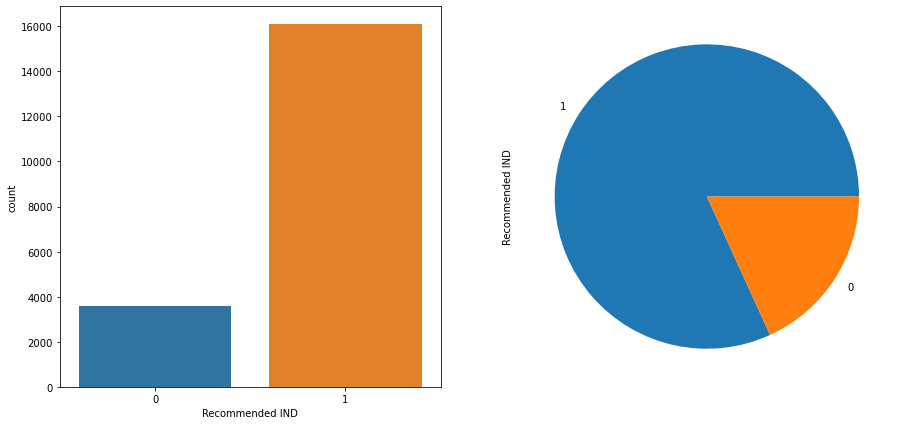

In [9]:
# Plot the counts targeted variable
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
sns.countplot(x = text_data['Recommended IND'])
plt.subplot(1, 2, 2)
text_data['Recommended IND'].value_counts().plot.pie(y = 'Class')

### 3. Please clean the new feature of Reviews using regular expressions.

In [10]:
#removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [11]:
# Remove all special characters, punctuation and spaces
text_data["Feature Reviews"] = text_data["Feature Reviews"].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
# Remove numbers 
text_data["Feature Reviews"] = text_data["Feature Reviews"].apply(lambda x: re.sub(r'[0-9]+', '', x))
# Remove words having length <=3 
text_data["Feature Reviews"] = text_data["Feature Reviews"].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,3}\b', '', x))
text_data.head()

,Recommended IND,Feature Reviews
2,0,Some major design flaws such high hopes thi...
3,1,favorite love love love this jumpsuit fl...
4,1,Flattering shirt This shirt very flattering ...
5,0,very petite love tracy reese dresses this...
6,1,Cagrcoal shimmer aded this basket last m...


### 4. Build an RNN model to forecast the Recommended IND based on Reviews using TensorFlow.

In [12]:
# Split data set into train and test data
X = text_data['Feature Reviews'].values
y = text_data['Recommended IND'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

In [13]:
# Print the data set 
print(f'X_train size  ={X_train.shape}; X_test size  ={X_test.shape}')

X_train size  =(14744,); X_test size  =(4915,)


In [14]:
# convert the text to numerical values using TextVectorization

# Specify the vocab size
VOCAB_SIZE = 10000
# Perform textvectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = VOCAB_SIZE)

# Fits the state of the preprocessing layer to the dataset.
encoder.adapt(X_train)

Metal device set to: Apple M1


2022-06-04 11:47:29.707203: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-04 11:47:29.707284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-04 11:47:29.736920: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-04 11:47:29.771524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [15]:
# Print the 50 vocab
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'this', 'general', 'with', 'dresses', 'dress', 'tops',
       'love', 'that', 'petite', 'size', 'very', 'have', 'great', 'like',
       'wear', 'just', 'they', 'fabric', 'small', 'would', 'color',
       'cute', 'perfect', 'knits', 'beautiful', 'really', 'more', 'look',
       'flattering', 'ordered', 'little', 'soft', 'these', 'bottoms',
       'jeans', 'will', 'nice', 'comfortable', 'well', 'pants', 'back',
       'because', 'shirt', 'large', 'than', 'sweater', 'blouses',
       'bought'], dtype='<U21')

In [16]:
# Create the RNN model
model = tf.keras.Sequential([
    # Convert review text to indices
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    # 
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    # Binary classifier
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
# Configure the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
# Train the model
%time
history = model.fit(x = X_train,y = y_train, batch_size = 32, epochs = 5,
          validation_data = (X_test,y_test), verbose = 1
          )

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Epoch 1/5


2022-06-04 11:47:35.386655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:47:36.004661: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_41/output/_17'
2022-06-04 11:47:36.007890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:47:36.233671: I tens

461/461 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7758

2022-06-04 11:48:23.521916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:48:23.870845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:48:24.018298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:48:24.060390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


461/461 [==============================] - 61s 121ms/step - loss: 0.4839 - accuracy: 0.7758 - val_loss: 0.3692 - val_accuracy: 0.8183
Epoch 2/5
461/461 [==============================] - 44s 96ms/step - loss: 0.2535 - accuracy: 0.8839 - val_loss: 0.2529 - val_accuracy: 0.8952
Epoch 3/5
461/461 [==============================] - 45s 98ms/step - loss: 0.2058 - accuracy: 0.9112 - val_loss: 0.2366 - val_accuracy: 0.8968
Epoch 4/5
461/461 [==============================] - 44s 96ms/step - loss: 0.1823 - accuracy: 0.9253 - val_loss: 0.2469 - val_accuracy: 0.8810
Epoch 5/5
461/461 [==============================] - 45s 97ms/step - loss: 0.1657 - accuracy: 0.9339 - val_loss: 0.2491 - val_accuracy: 0.8887


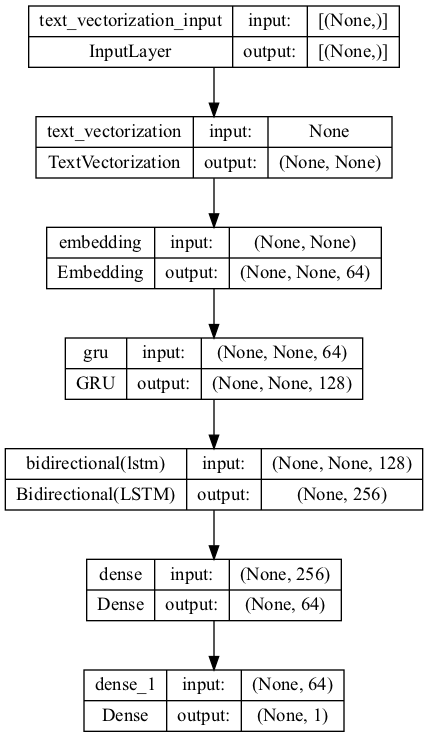

In [19]:
# Model architecture
tf.keras.utils.plot_model(model, show_shapes = True)

### 5. Evaluate the model and check the model fit. Do you recommend this model? Please justify your answer.

Text(0.5, 1.0, 'Training and Validation Loss')

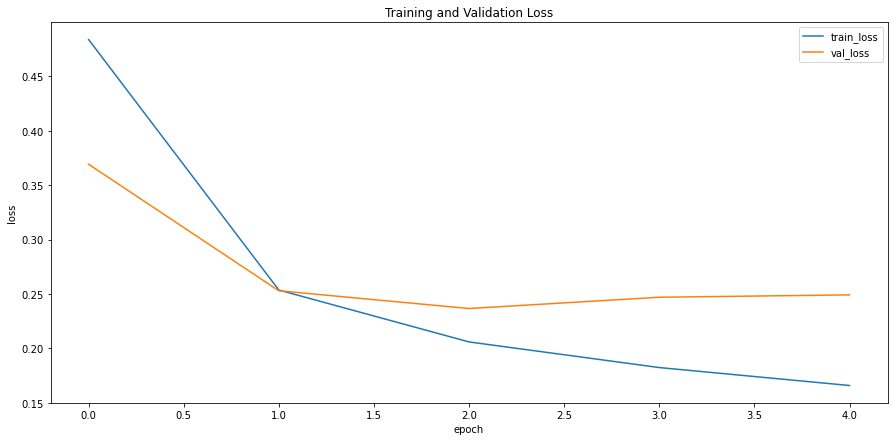

In [20]:
# Model diagnostics/Evaluate the Model
plt.figure(figsize = (15,7))
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

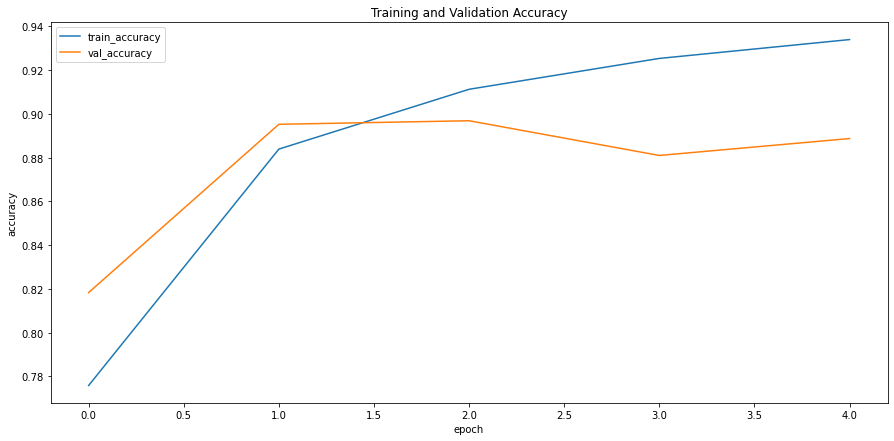

In [21]:
plt.figure(figsize = (15,7))
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')

In [22]:
# Forcast the label
# the cutoff probability is 50%
y_pred = (model.predict(X_test)> 0.5).astype(int)

2022-06-04 11:51:33.656939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:51:34.012799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:51:34.217629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 11:51:34.268055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


154/154 [==============================] - 11s 58ms/step


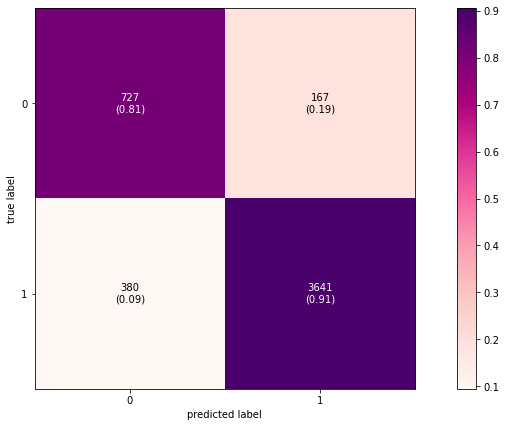

In [23]:
# Plot confusion matrix
#plt.figure(figsize = (15,7))
fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(y_test, y_pred),
                                show_absolute = True,
                                show_normed = True,
                                colorbar = True, 
                                cmap = "RdPu",
                               figsize = (15,7))

In [24]:
# Print the classification report 
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names = label_names))

              precision    recall  f1-score   support

    negative       0.66      0.81      0.73       894
    positive       0.96      0.91      0.93      4021

    accuracy                           0.89      4915
   macro avg       0.81      0.86      0.83      4915
weighted avg       0.90      0.89      0.89      4915



The accuracy and f1-score is larger than 90%. It is a decent model.